<img src="dsci512_header.png" width="600">

# Lecture 6

In [1]:
import numpy as np
import networkx as nx
import scipy.sparse
import urllib.request
from collections import Counter

In [2]:
# The defaults are hard to see on a projector in class
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
%config InlineBackend.figure_formats = ['svg']

draw_params = {
    "node_color": "pink",
    "font_size": 16,
    "with_labels": True,
    "arrowsize": 15,
    # "width": 1
    # "node_size": 200
}

Outline:

- Centrality, PageRank (15 min)
- Other graph properties (5 min)
- Graph representations: adjacency matrices, adjacency lists (5 min)
- Sparse matrices part 1 (15 min)
- Break (5 min)
- Sparse matrices part 2 (15 min)
- Sparse matrix timing (15 min)
- Activities (time-permitting)

## Learning objectives

- Describe the PageRank algorithm.
- Convert between adjacency matrices and their corresponding graphs.
- Manipulate scipy sparse matrix objects in Python.
- Analyze the space complexity of sparse and dense matrix representations.
- Appropriately use row-wise vs. column-wise sparse matrices.

## Centrality, PageRank (10 min)


In [3]:
sfg = nx.scale_free_graph(10, seed=20)

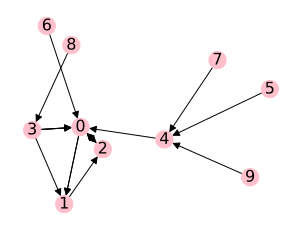

In [4]:
nx.draw(sfg, **draw_params, pos=nx.spring_layout(sfg, seed=1))

- Which is the most "important" webpage here? Perhaps $0$ or $1$? 
- This is a question known as [centrality](https://en.wikipedia.org/wiki/Centrality). 
  - See also the idea of a [hub](https://en.wikipedia.org/wiki/Hub_(network_science)) (not discussed further).
- We'll focus on a particular measure of centrality, [PageRank](https://en.wikipedia.org/wiki/PageRank).
    - This is the algorithm that made Google the best search engine.

- Conceptual model: let websites be nodes in a graph.
  - Put a directed edge from site $A$ to $B$ if site $A$ links to site $B$.
- There is a specific definition of PageRank.
  - The way to find it is mathematically beautiful and is essentially a linear algebra problem.
  - That is beyond the scope here.

- But we can approximate the PageRank with Monte Carlo, with a "simulated web surfer", as follows:
  1. We start at some random node
  2. With probability $\alpha$ choose a completely random node in the graph (this emulates the user going to a random new page); with probability $(1−\alpha)$ choose a random neighbour of the current node (this emulates the user clicking on a link on the page). 
  3. Repeat Step 2 $n$ times.
  4. The ranking of each node is proportional to the number of times this random walk visits the node.
- To repeat, this is **not** how Google computes PageRank; there is a more elegant/efficient way.

In [5]:
def page_rank(G, alpha=0.1, iters=100_000):
    """
    Compute the PageRank for all nodes in the directed graph G.
    Returns a dictionary of the PageRank for all nodes.

    Parameters
    ----------
    G : networkx.classes.graph.DiGraph
        the graph
    alpha : float
        the probability of surfing to a random page
    iters : int
        the number of iterations of simulation to perform

    Returns
    -------
    collections.Counter 
        A dictionary containing the PageRank for each node.

    Example
    --------
    >>> pr = page_rank(nx.scale_free_graph(3))
    Counter({2: 33349, 0: 33371, 1: 33280})
    """

    visited = Counter()

    nodes = G.nodes()
    current_node = np.random.choice(nodes)
    for i in range(iters):
        if np.random.random() < alpha:
            current_node = np.random.choice(nodes)
        else:
            current_node = np.random.choice(list(G.neighbors(current_node)))
        visited[current_node] += 1

    return visited

Let's look at the code:

- We start at a random node.
- For each iteration:
- With probability $\alpha$, go to a random node.
- Else (with probability $1-\alpha$) go to a random neighbour.
- Keep score whenever you visit a node.
- That's it!

In [6]:
pr = page_rank(sfg)

In [7]:
pr.most_common()

[(0, 36715),
 (2, 34095),
 (1, 18440),
 (4, 3760),
 (3, 1957),
 (9, 1060),
 (5, 1037),
 (8, 1035),
 (6, 965),
 (7, 936)]

Here's the graph again, so it's nearby:

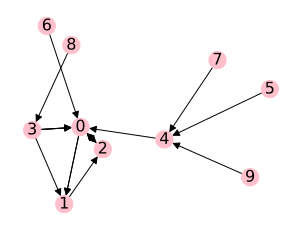

In [8]:
nx.draw(sfg, **draw_params, pos=nx.spring_layout(sfg, seed=1))

- **Question**: node $0$ is has the highest PageRank; that makes sense. But why is node $2$ above node $4$? 

<br><br><br><br><br><br><br><br>

- **Answer**: because node $0$ is the most important, and there is no path from $0$ to $4$. 
- So, a link from a popular page is more valuable than a link from a no-name page. Makes sense!
- We can just sort the pages by number of incoming links, and we see we get a different (worse) ranking:

In [9]:
num_neigh = {i: len(list(nx.reverse_view(sfg).neighbors(i)))
             for i in sfg.nodes()}
for node in sorted(num_neigh, key=num_neigh.get, reverse=True):
    print("Node", node, "has", num_neigh[node], "incoming links")

Node 0 has 4 incoming links
Node 4 has 3 incoming links
Node 1 has 2 incoming links
Node 2 has 2 incoming links
Node 3 has 1 incoming links
Node 5 has 0 incoming links
Node 6 has 0 incoming links
Node 7 has 0 incoming links
Node 8 has 0 incoming links
Node 9 has 0 incoming links


Here, indeed, we get node $4$ above nodes $1$ and $2$.

Optional note: there are two sources of "randomness" here:

- The fact that the model is inherently probabilistic (do this with probability $\alpha$)
- The limitations of our simulation (start at one random node, finite number of iterations)

These are very different from each other. You can mathematically find the true PageRank, which solves the second problem. The first one is not a problem though, it is just part of the definition of PageRank.

You may encounter similar concepts to this in the Stat courses.

## (optional) Other graph properties (5 min)

There are a lot of standard problems in graph theory, not covered in this course, such as:

- Find the largest [clique](https://en.wikipedia.org/wiki/Clique_(graph_theory)) in a graph.
- Find the largest [independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)) in a graph.
- Find the [vertex cover](https://en.wikipedia.org/wiki/Vertex_cover) of a graph with the smallest number of vertices.
- Find the smallest [dominating set](https://en.wikipedia.org/wiki/Dominating_set) in a graph.
- [Colour](https://en.wikipedia.org/wiki/Graph_coloring) a graph with the smallest number of colours.

It turns out a lot of real-world problems can be mapped to these problems, and thus solving these problems is important. 

- **However**, they are [NP-Complete](https://www.geeksforgeeks.org/np-completeness-set-1/).
  - You may have heard this term.
  - We aren't going into this here due to lack of time.
  - But, in short, we don't have fast algorithms to solve these problems. 

## Graph representations (10 min)

In [10]:
G = nx.bull_graph()

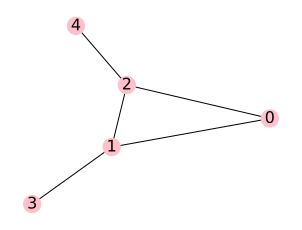

In [11]:
nx.draw(G, **draw_params)

We can represent the graph as an _adjacency list_. It lists all pairs of vertices that are connected, for example $(0,1)$.

In [12]:
print(G.edges())

[(0, 1), (0, 2), (1, 2), (1, 3), (2, 4)]


Or, we can represent the graph as an _adjacency matrix_. 

In [13]:
adj = nx.adjacency_matrix(G).toarray()
adj

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_54313/2435146153.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [14]:
adj[0, :]

array([0, 1, 1, 0, 0])

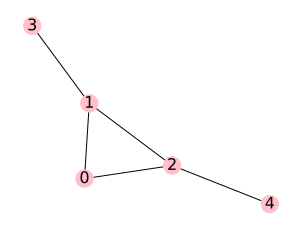

In [15]:
nx.draw(G, **draw_params)

Note that this is a symmatric matrix.

In [16]:
G.nodes

NodeView((0, 1, 2, 3, 4))

- This matrix has size `# vertices` x `# vertices`
- This representation is often nice. For example we can check if any two nodes $i$ and $j$ are connected in $O(1)$ time:

In [17]:
adj[1, 3]

1

**Question:** What is the space complexity of these two representations? 

<br><br><br><br><br>



Let $E$ be the number of edges and $V$ be the number of vertices.

- Adjacency list: $O(E)$
- Adjacency matrix: $O(V^2)$

**Question:** Which is better?

<br><br><br><br><br><br><br><br>

- **Answer:** the list takes up less space, but lookup is slower.
- Though, in the worst case of a complete graph, then $E=O(V^2)$ and the two are about the same space. 

Wouldn't it be great if we could have the lookup speed of the adjacency matrix, with the storage requirements of an adjacency list? We almost can, by storing a structured adjacency list. Enter sparse matrices.

## Sparse matrices (30 min)

*Terminology alert*: 

- In math, a sparse matrix is a matrix with a lot of zeros in it.
- In coding, a sparse matrix is a data structure.
- _This is extremely confusing!_
- It is a good idea to use a sparse matrix data structure when you have a sparse matrix.
  - But it is _possible_ to use a sparse matrix data structure when your matrix is not sparse.
  - And it is _possible_ to use a dense matrix data structure (e.g. numpy array) when your matrix is sparse.

In [18]:
G = nx.ladder_graph(5)

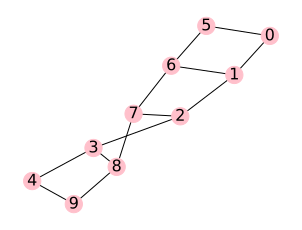

In [19]:
nx.draw(G, **draw_params)

In [20]:
am_ladder = nx.adjacency_matrix(G)

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_54313/1191222007.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  am_ladder = nx.adjacency_matrix(G)


In [21]:
am_ladder

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [22]:
type(am_ladder)

scipy.sparse._csr.csr_matrix

- Sparse matrices are conceptual data structure like a list, dictionary, set, etc.
- [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) matrices are the Python implementation of this conceptual data structure, like `list`, `dict`, `set`, etc.
- Going to that link, we can see there are many types of scipy sparse matrix.
  - This one is a [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
  - More later on these types.
- You can convert them to numpy arrays with `toarray()`, but this is usually a bad idea.

In [23]:
print(am_ladder.toarray())

[[0 1 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 1 0 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 1 0]]


In [24]:
type(am_ladder.toarray())

numpy.ndarray

In [25]:
type(am_ladder)

scipy.sparse._csr.csr_matrix

In [26]:
# make a bigger graph with more vertices/edges
G = nx.fast_gnp_random_graph(100_000, 1e-4)

In [27]:
type(G)

networkx.classes.graph.Graph

In [28]:
len(G.nodes)

100000

In [29]:
len(G.edges)

499608

In [30]:
am = nx.adjacency_matrix(G)

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_54313/2653877533.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  am = nx.adjacency_matrix(G)


In [31]:
am.shape

(100000, 100000)

In [32]:
am.nnz

999216

- Okay, so we have a $100,000 \times 100,000$ matrix, which would have $10^{10}$ elements.
- But only around $10^6$ of them are non-zero. Or 0.01% nonzero.
  - We say "this matrix is very sparse".
  
How bad would it be to store this as a numpy array?

Stored in full form, the matrix would take up:

In [33]:
full_size = np.prod(am.shape)*8/1e9
print("The full matrix would take up %d GB" % full_size)

The full matrix would take up 80 GB


That's a lot! How big is the sparse matrix?

In [34]:
sparse_size = (am.data.nbytes + am.indptr.nbytes + am.indices.nbytes)/1e6
print("The sparse matrix takes up %d MB" % sparse_size)

The sparse matrix takes up 12 MB


So, the fraction of space saved is:

In [35]:
frac_nz = am.nnz / np.prod(am.shape)
print("The sparse matrix is %dx smaller" % (1/frac_nz))

The sparse matrix is 10007x smaller


- Right, so we definitely don't want to store the full matrix.
- Let's do some operations on the sparse matrix.


## Break (5 min)

## Sparse matrices continued (15 min)

- Quick preview of how this works:
  - Store only the nonzero elements
  - By row/column
  - More general than adjacency list

Get all neighbours of vertex $i$:

In [36]:
i = 0
print(am[i])

  (0, 40813)	1
  (0, 48962)	1
  (0, 53444)	1
  (0, 65692)	1
  (0, 79653)	1
  (0, 81771)	1
  (0, 84250)	1
  (0, 92524)	1


#### Notational nuisances

- There are some weird things to know about scipy sparse matrices.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [37]:
x = np.random.rand(10, 10)

In [38]:
x[1, 2]

0.5218922875499903

In [39]:
x[1][2]

0.5218922875499903

In [40]:
(x[1])[2]

0.5218922875499903

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [41]:
x[1]

array([0.18582985, 0.18103642, 0.52189229, 0.00964829, 0.77891394,
       0.29809204, 0.93515516, 0.16305907, 0.40988807, 0.23854484])

In [42]:
row_1 = x[1]
row_1[2]

0.5218922875499903

However, with `scipy.sparse` matrices, things are a bit different:

In [43]:
x_sparse = scipy.sparse.csr_matrix(x)

In [44]:
x_sparse[1, 2]

0.5218922875499903

In [45]:
x_sparse[1][2]

IndexError: row index (2) out of range

In [ ]:
x_sparse[1]

Why?

In [ ]:
row_1_sparse = x_sparse[1]

In [46]:
row_1_sparse.shape

NameError: name 'row_1_sparse' is not defined

In [47]:
# print(row_1_sparse)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [48]:
lst = [[1, 2, 3], [4, 5, 6], [7, 9]]
lst

[[1, 2, 3], [4, 5, 6], [7, 9]]

In [49]:
lst[0][1]

2

In [50]:
lst[0, 1]

TypeError: list indices must be integers or slices, not tuple

#### Sparse matrix operations

- Let's try to find the vertex with the most neighbours.
- First, some numpy syntax:

In [51]:
x = np.random.randint(10, size=(4,5))
x

array([[7, 0, 4, 3, 5],
       [4, 1, 9, 6, 8],
       [6, 0, 6, 1, 0],
       [7, 4, 6, 1, 9]])

In [52]:
np.sum(x)

87

In [53]:
x.sum() # <- do it this way for sparse matrices (for numpy either is fine)

87

In [54]:
np.sum(x, axis=0)

array([24,  5, 25, 11, 22])

In [55]:
np.sum(x, axis=1)

array([19, 28, 13, 27])

Back to the adjacency matrix, this operation counts the nonzeros for each row of the matrix:

In [56]:
am.getnnz(axis=1)

array([ 8, 14,  8, ...,  8,  8,  7], dtype=int32)

In [57]:
ind = np.argmax(am.getnnz(axis=1))
val = np.max(am.getnnz(axis=1))

print("Vertex", ind, "has", val, "neighbours")

Vertex 85727 has 26 neighbours


#### sparse data sets

Sparse matrices come up _a lot_ in practice, beyond just adjacency matrices in graphs. For example:

- Word counts: we might represent a document by which words are in it, but only a small fraction of all words would appear in a given document.
- Ratings: we might represent an Amazon item by the user ratings, but only a small fraction of all users have rated a given item.
- Physical processes: in a 2019 Capstone project, students examined images from a particle physics dataset, in which most of the sensors got zero signal.
- etc.

#### (optional) nearest neighbours with sparse matrices

- In Lecture 4 we discussed nearest neighbour algorithms.
- We need to think carefully about the idea of _distance_ when dealing with sparse vectors.
  - Euclidean distance doesn't necessarily make sense.
  - It may depend if we have sparse vectors of sparse _binary_ vectors (like in the adjacency matrix).
  - Both are common in practice.
  - For sparse binary vectors, the distance could just be the number of places they differ.
  - E.g. $\text{dist}((0,0,1), (0,1,1))=1$ because they differ in one place (the second entry).
- Different nearest neighbour algorithms might need to be used for sparse vectors.
- E.g. $k$-d trees don't really make sense because "dividing the space in half" doesn't really do anything interesting; they are already divided.

## Spare matrix timing (15 min)

- The amount of time things take with sparse matrices can be quite surprising. 
- First off, let's look at regular numpy arrays.

In [58]:
numpy_array = np.random.rand(10000, 10000)

- Numpy arrays are actually stored row-by-row, so summing a row is faster that summing a column:

In [59]:
%timeit numpy_array[0,:].sum() # sum the first row

3.9 µs ± 14.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
%timeit numpy_array[:,0].sum() # sum the first column

38.3 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Overall, both of these are _much_ faster than summing the whole thing (which makes sense!):

In [61]:
%timeit numpy_array.sum()

35.4 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Per row or per column, summing the whole thing takes:

In [63]:
3_540/10000

0.354

which is faster than summing a row. It makes sense that a bigger, vectorized operation has some savings.

Now let's look at sparse matrices:

In [64]:
G = nx.fast_gnp_random_graph(10_000, 0.25e-2)
sparse_matrix = nx.adjacency_matrix(G)

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_54313/1006145731.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse_matrix = nx.adjacency_matrix(G)


In [65]:
len(G.nodes)

10000

In [66]:
len(G.edges)

125344

In [67]:
type(G)

networkx.classes.graph.Graph

In [68]:
%timeit sparse_matrix[0,:].sum()

60.2 µs ± 263 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
%timeit sparse_matrix[:,0].sum()

538 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [70]:
%timeit sparse_matrix.sum()

259 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


- Notice also how summing the first row is faster than summing the first column.
- This has to do with the type of sparse matrix:

#### (optional) Sparse matrix format, the gory details

In [71]:
type(sparse_matrix)

scipy.sparse._csr.csr_matrix

- This is "Compressed Sparse Row" format.
- It means we store an adjacency list _per row_. 
- So if we want Row 4, we just grab it right away.
- But if we want column 4, we have to iterate through every row and check if there's a 4!

In [72]:
x = scipy.sparse.random(5, 5, density=0.2, format="csr", random_state=321)

print(x.toarray())

[[0.86182738 0.         0.         0.         0.        ]
 [0.         0.         0.         0.36493942 0.        ]
 [0.         0.         0.52952801 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.84758728 0.         0.98840654 0.         0.        ]]


In [73]:
print(x)

  (0, 0)	0.8618273768819481
  (1, 3)	0.3649394158657733
  (2, 2)	0.529528005602308
  (4, 0)	0.8475872823428623
  (4, 2)	0.9884065398125097


Here's how it is actually stored:

In [74]:
x.data

array([0.86182738, 0.36493942, 0.52952801, 0.84758728, 0.98840654])

In [75]:
x.indices # column indices

array([0, 3, 2, 0, 2], dtype=int32)

In [76]:
x.indptr 

array([0, 1, 2, 3, 3, 5], dtype=int32)

Above: 

- Row 0 starts at `x.indices[0]`
- Row 1 starts at `x.indices[1]`
- Row 2 starts at `x.indices[2]`
- Row 3 starts at `x.indices[3]`
- Row 4 also starts at `x.indices[3]`, because row 3 is empty
- Row 5 starts at `x.indices[5]`

Here is a diagram that makes these numbers much more understandable:

<img src="https://i.stack.imgur.com/12bPL.png" width="800">

([Image source](https://stackoverflow.com/a/52299730/8823277))

We can actually convert between sparse matrix types.

In [77]:
sparse_csc = sparse_matrix.tocsc()

In [78]:
%timeit sparse_csc[0,:].sum() # used to be faster

530 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
%timeit sparse_csc[:,0].sum() # used to be slower

62.9 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Other notes on using sparse matrices: 

- Use vectorized built-in scipy operations as much as possible.
- Avoid loops.
- For extra optimizations, keep in mind what type of sparse matrix you have.